All codes are taken from the "Hands on 3" notebook. I just modified them according to the requirements of the homework with minor help from ChatGPT.

### الف

In [6]:
!pip install -U gymnasium

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm, trange
from typing import Optional
import plotly.graph_objects as go

In [3]:
def visualize(data, time, title):

    fig = go.Figure()
    
    # Add the regret trace
    fig.add_trace(go.Scatter(
        x=time,
        y=data,
        mode='lines',
        name=title,
        line=dict(color='red')
    ))
    
    # Add labels and title
    fig.update_layout(
        title=f'{title} Over Time',
        xaxis_title='Episode',
        yaxis_title='Value',
        legend_title='Legend'
    )
    
    # Show the plot
    fig.show()

In [13]:
import numpy as np
from typing import Optional
from tqdm import trange

class QLearning:
    def __init__(self, env, learning_rate=0.1, discount=0.99, epsilon=1.0, epsilon_decay: Optional[float] = None, lr_decay: Optional[float] = None):
        """
        Initialize the Q-learning algorithm.
        :param env: Environment object (e.g., OpenAI Gym)
        :param learning_rate: Initial learning rate
        :param discount: Discount factor for future rewards
        :param epsilon: Initial epsilon for epsilon-greedy policy
        :param epsilon_decay: Decay factor for epsilon (optional)
        :param lr_decay: Decay factor for learning rate (optional)
        """
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.q_table = np.zeros((self.state_size, self.action_size))
        
        self.learning_rate = learning_rate
        self.initial_lr = learning_rate
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.lr_decay = lr_decay

    def update_learning_rate(self, epoch, min_lr=0.0001):
        """
        Updates the learning rate based on the decay factor.
        :param epoch: Current training episode
        :param min_lr: Minimum learning rate
        :return: Updated learning rate
        """
        if self.lr_decay:
            return max(self.initial_lr * (self.lr_decay ** epoch), min_lr)
        return self.learning_rate

    def get_action(self, state):
        """
        Select an action using an epsilon-greedy policy.
        :param state: Current state
        :return: Action to take
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def train(self, episodes):
        """
        Train the Q-learning algorithm over a number of episodes.
        :param episodes: Number of training episodes
        :return: Tuple (regrets, total_rewards, frames, q_table)
        """
        regrets = []
        total_rewards = []
        frames = []

        for episode in trange(episodes, desc="Training"):
            state, _ = self.env.reset()
            total_reward = 0
            optimal_reward = 1

            while True:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                # Q-learning update rule
                current_q = self.q_table[state, action]
                next_max_q = np.max(self.q_table[next_state])
                self.q_table[state, action] = (1 - self.learning_rate) * current_q + \
                                              self.learning_rate * (reward + self.discount * next_max_q)
                
                total_reward += reward
                state = next_state

                if episode == episodes - 1:
                    frames.append(self.env.render())
                
                if terminated or truncated:
                    # Calculate regret if optimal_reward is defined
                    regret = optimal_reward - total_reward if optimal_reward else 0
                    regrets.append(regret)
                    total_rewards.append(total_reward)
                    break

            if self.lr_decay is not None:
                self.learning_rate = self.update_learning_rate(epoch=episode)
        
            if self.epsilon_decay:
                self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)

        return regrets, total_rewards, frames, self.q_table


In [18]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()

num_episodes = 200

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.01
lr_decay = 0.001


agent = QLearning(env, learning_rate=learning_rate, discount=discount, epsilon_decay=epsilon_decay, epsilon=epsilon)
regrets, rewards, frames, q_table = agent.train(num_episodes)

Training: 100%|█████████████████████████████| 200/200 [00:00<00:00, 1110.04it/s]


In [19]:
q_table

array([[  -6.46525605,   -6.45835574,   -6.44091785,   -6.44279544],
       [  -6.3211202 ,   -6.31352954,   -6.32421315,   -6.34212688],
       [  -6.10626266,   -6.11644275,   -6.13950911,   -6.10943499],
       [  -5.8663366 ,   -5.87461979,   -5.89662622,   -5.88174494],
       [  -5.59880503,   -5.58269358,   -5.5693999 ,   -5.61998064],
       [  -5.26932052,   -5.2537782 ,   -5.2706971 ,   -5.26128907],
       [  -4.87859716,   -4.86851678,   -4.90882302,   -4.94237364],
       [  -4.4523979 ,   -4.44759907,   -4.48146572,   -4.50806598],
       [  -4.03269725,   -4.00929703,   -4.02538183,   -4.01449531],
       [  -3.5685558 ,   -3.54181713,   -3.53028845,   -3.53749836],
       [  -3.07990333,   -3.04505071,   -3.05971829,   -3.06103953],
       [  -2.56507195,   -2.58583304,   -2.55962988,   -2.64422723],
       [  -6.55482149,   -6.57098123,   -6.57634029,   -6.56347077],
       [  -6.39940788,   -6.39115825,   -6.42084414,   -6.39388734],
       [  -6.17399167,   -6.165125

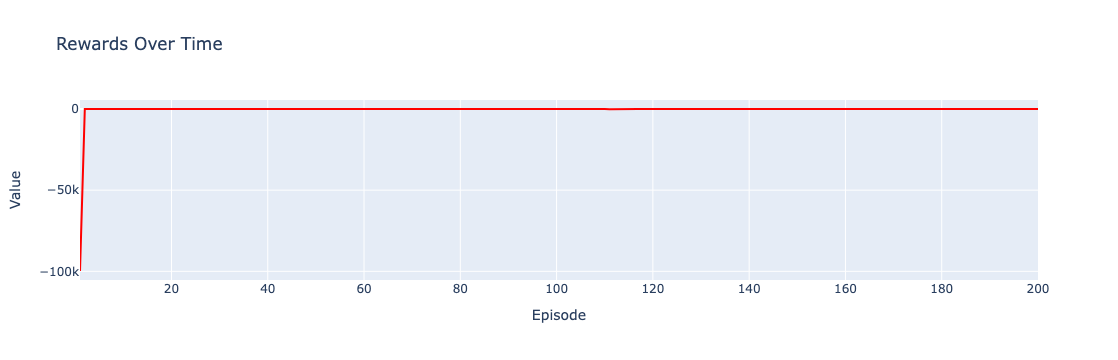

In [20]:
visualize(rewards, list(range(1, num_episodes+1)), 'Rewards')

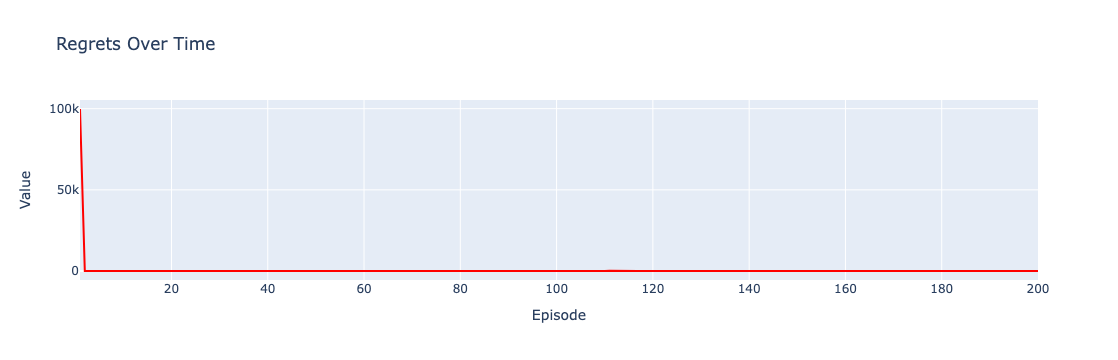

In [21]:
visualize(regrets, list(range(1, num_episodes+1)), 'Regrets')

In [22]:
print(rewards[:10])
print(rewards[-10:])

[-99799, -57, -62, -82, -56, -71, -67, -47, -86, -46]
[-20, -43, -16, -23, -13, -23, -15, -31, -21, -13]


In [31]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()

num_runs = 3
num_episodes = 200

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.01


agent = QLearning(env, learning_rate, discount, epsilon_decay, lr_decay=0.05)
regrets, rewards, frames, q_table = agent.train(num_episodes)

Training: 100%|██████████████████████████████| 200/200 [00:00<00:00, 346.73it/s]


In [32]:
q_table

array([[ -1.21643273,  -1.21648979,  -1.21650547,  -1.21643273],
       [ -1.15458283,  -1.1546141 ,  -1.15464983,  -1.15459876],
       [ -1.08388249,  -1.08387567,  -1.08393451,  -1.08387985],
       [ -0.99144623,  -0.99142503,  -0.99146703,  -0.99144498],
       [ -0.89705744,  -0.89706755,  -0.89714573,  -0.89710966],
       [ -0.79832054,  -0.79832446,  -0.79838037,  -0.7984187 ],
       [ -0.70679885,  -0.70678832,  -0.70686474,  -0.70678366],
       [ -0.61335447,  -0.61335506,  -0.6133585 ,  -0.61345264],
       [ -0.52715943,  -0.52724603,  -0.5272162 ,  -0.52725453],
       [ -0.44904817,  -0.44908686,  -0.44909203,  -0.44903324],
       [ -0.38224296,  -0.38226397,  -0.38226704,  -0.38223347],
       [ -0.3383101 ,  -0.33831011,  -0.33827819,  -0.33837522],
       [ -1.26080878,  -1.26087657,  -1.26080347,  -1.26081125],
       [ -1.17678814,  -1.17679511,  -1.17672812,  -1.17678444],
       [ -1.08232745,  -1.0823315 ,  -1.08240145,  -1.08233372],
       [ -0.98029074,  -0

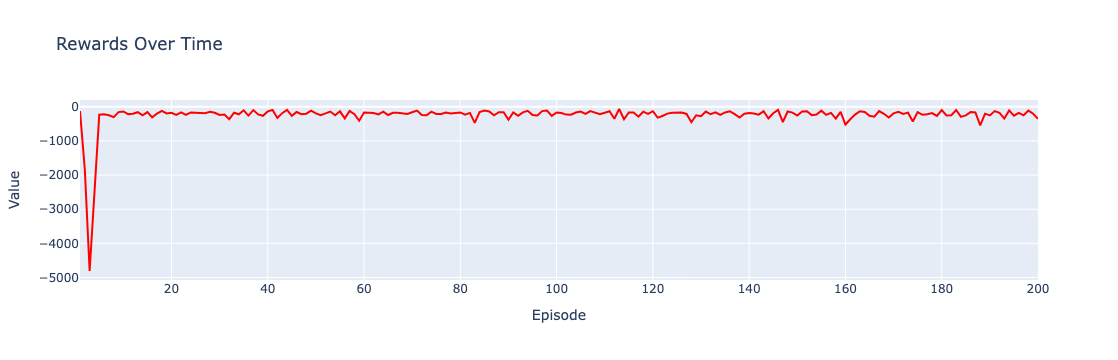

In [33]:
visualize(rewards, list(range(1, num_episodes+1)), 'Rewards')

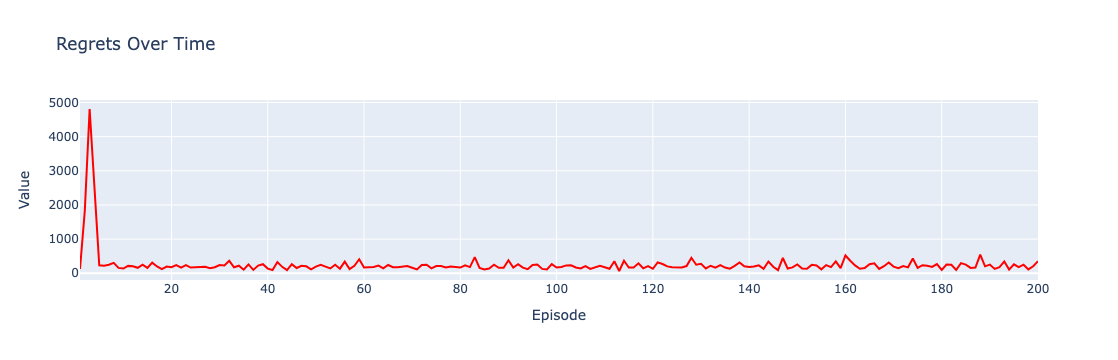

In [34]:
visualize(regrets, list(range(1, num_episodes+1)), 'Regrets')

In [27]:
print(rewards[:10])
print(rewards[-10:])

[-641, -1447, -2093, -747, -339, -66, -89, -120, -153, -242]
[-273, -110, -198, -378, -201, -180, -198, -217, -114, -298]


The version without a learning rate decay converges much faster while the one with a learning rate decay.  
Also the one with the learning rate decay has more deviation after convergence.  
Epsilon and Learning Rate are both decaying linearly:
- self.learning_rate = max(self.initial_lr * (self.lr_decay ** epoch), min_lr)
- self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)

### ب

In [54]:
class SARSA:

  def __init__(self, env, learning_rate = 0.1, discount = 0.99, epsilon = 1, epsilon_decay:Optional[float]= None):

    self.env = env
    self.state_size = env.observation_space.n
    self.action_space = env.action_space
    self.action_size = env.action_space.n
    self.q_table = np.zeros((self.state_size, self.action_size))

    self.learning_rate = learning_rate
    self.discount = discount
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = 0.01


  def get_action(self, state):
    if np.random.rand() < self.epsilon:
      return env.action_space.sample()
    else:
      return np.argmax(self.q_table[state])

  def train(self, episodes):

    regrets = []
    total_rewards = []
    frames = []

    for episode in trange(episodes):

      state, _ = self.env.reset()
      action = self.get_action(state)
      total_reward = 0
      frames_per_episode = []

      while True:

        next_state, reward, terminated, truncated, _  = self.env.step(action)
        next_action = self.get_action(next_state)

        current_q = self.q_table[state, action]
        next_q = self.q_table[next_state, next_action]

        # Write SARSA updating rule
        new_q = current_q + self.learning_rate * (reward + self.discount * next_q - current_q)
        self.q_table[state , action] = new_q


        total_reward += reward
        state = next_state
        action = next_action

        if terminated or truncated:
          # Calcualte regret
          regret = 1 - total_reward
          regrets.append(regret)
          total_rewards.append(total_reward)
          break

        if episode % 20 == 0:
          frames_per_episode.append(self.env.render())

      if frames_per_episode:
        frames.append(frames_per_episode)

      if (self.epsilon_decay) and (self.epsilon > self.epsilon_min):
        self.epsilon = self.epsilon * self.epsilon_decay

    return regrets, total_rewards, frames, self.q_table




class TreeBackupNStep:
    def __init__(self, env, learning_rate=0.1, discount=0.99, epsilon=1, epsilon_decay: Optional[float] = None, n_steps=5):
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.q_table = np.zeros((self.state_size, self.action_size))

        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.n_steps = n_steps  # n-step parameter

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def train(self, episodes):
        regrets = []
        total_rewards = []

        for episode in trange(episodes):
            state, _ = self.env.reset()
            action = self.get_action(state)
            total_reward = 0

            # Initialize buffer for (state, action, reward)
            buffer = []
            t = 0

            while True:
                # Perform the action
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                next_action = self.get_action(next_state)
                buffer.append((state, action, reward))

                total_reward += reward
                t += 1

                # Compute n-step updates if enough transitions are in the buffer
                if len(buffer) >= self.n_steps:
                    G = sum(
                        self.discount ** i * buffer[i][2] for i in range(self.n_steps)
                    )
                    if not (terminated or truncated):
                        G += (
                            self.discount ** self.n_steps
                            * np.max(self.q_table[next_state])
                        )

                    # Update Q-value for the first (state, action) in the buffer
                    s, a, _ = buffer.pop(0)
                    self.q_table[s, a] += self.learning_rate * (G - self.q_table[s, a])

                # End the episode if done
                if terminated or truncated:
                    # Final updates for remaining buffer elements
                    while buffer:
                        G = sum(
                            self.discount ** i * buffer[i][2]
                            for i in range(len(buffer))
                        )
                        s, a, _ = buffer.pop(0)
                        self.q_table[s, a] += self.learning_rate * (G - self.q_table[s, a])

                    regrets.append(1 - total_reward)  # Adjust this based on regret definition
                    total_rewards.append(total_reward)
                    break

                # Advance to the next state-action pair
                state = next_state
                action = next_action

            # Decay epsilon
            if self.epsilon_decay:
                self.epsilon = max(
                    self.epsilon * self.epsilon_decay, self.epsilon_min
                )

            # Decay learning rate (optional)
            self.learning_rate = max(self.learning_rate * 0.99, 0.01)

        return regrets, total_rewards


In [50]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()

num_runs = 3
num_episodes = 200

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.01


agent = SARSA(env, learning_rate, discount, epsilon_decay)
regrets, rewards, frames, q_table = agent.train(num_episodes)

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 502.64it/s]


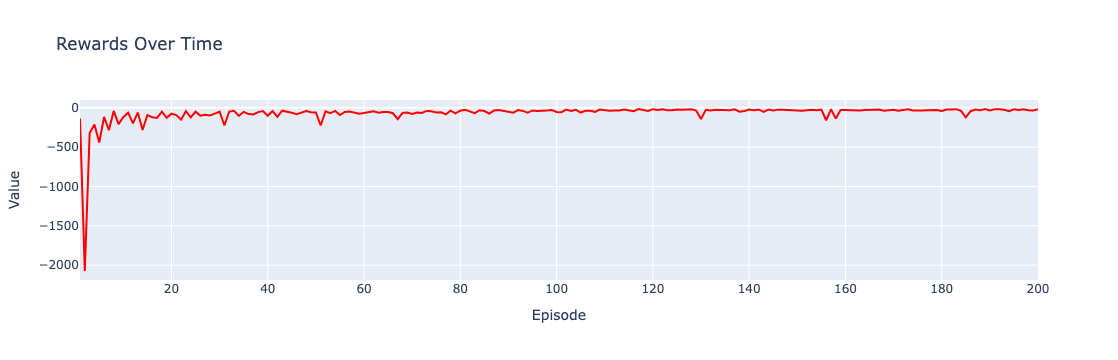

In [51]:
visualize(rewards, list(range(1, num_episodes+1)), 'Rewards')

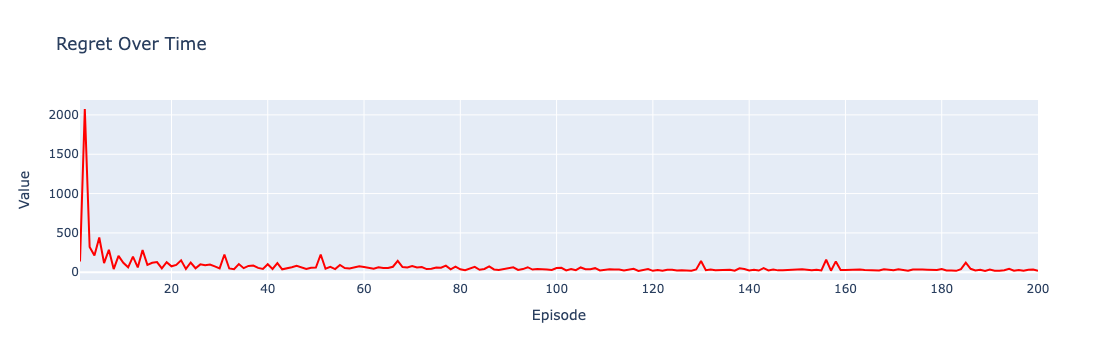

In [52]:
visualize(regrets, list(range(1, num_episodes+1)), 'Regret')

In [59]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()

num_runs = 3
num_episodes = 200

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.01


agent = TreeBackupNStep(env, learning_rate=learning_rate, discount=discount, epsilon_decay=epsilon_decay, n_steps=1)
regrets, total_rewards = agent.train(num_episodes)

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1086.73it/s]


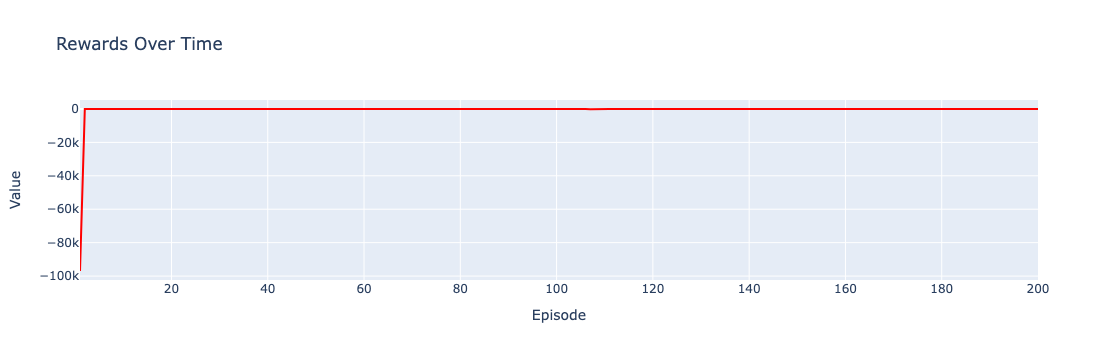

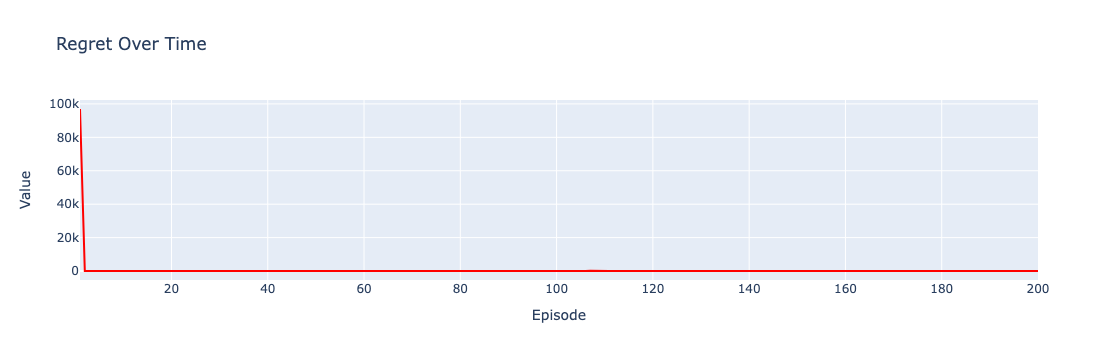

In [60]:
visualize(total_rewards, list(range(1, num_episodes+1)), 'Rewards')
visualize(regrets, list(range(1, num_episodes+1)), 'Regret')

In [61]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()

num_runs = 3
num_episodes = 200

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.01


agent = TreeBackupNStep(env, learning_rate=learning_rate, discount=discount, epsilon_decay=epsilon_decay, n_steps=4)
regrets, total_rewards = agent.train(num_episodes)

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 264.55it/s]


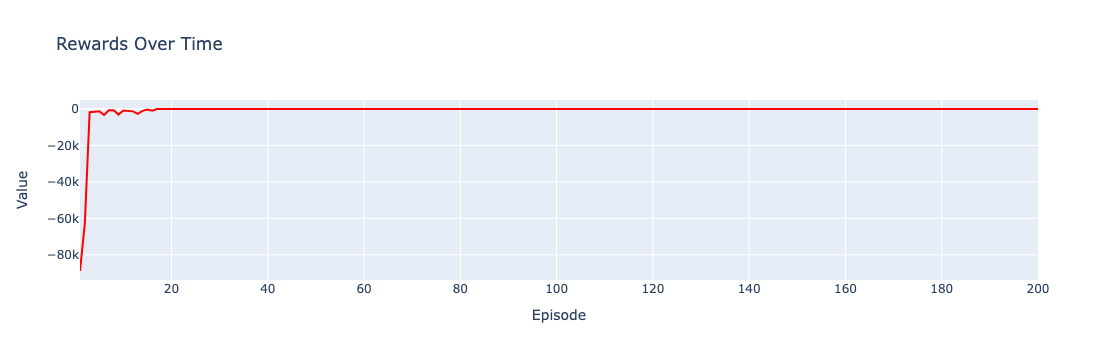

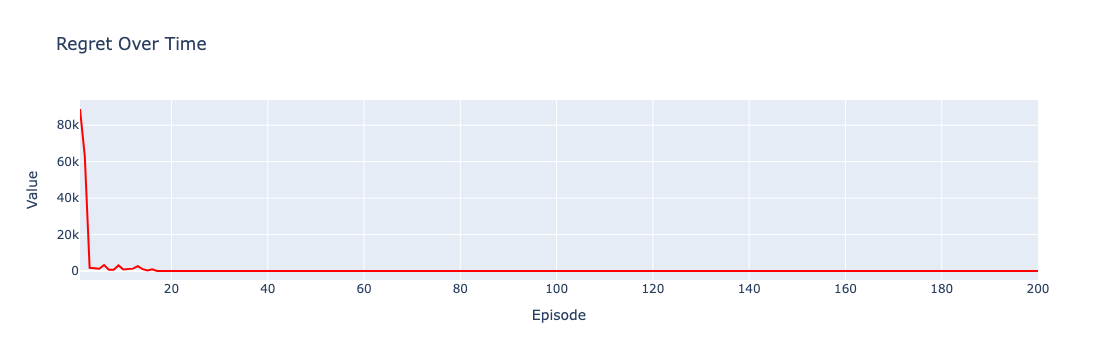

In [62]:
visualize(total_rewards, list(range(1, num_episodes+1)), 'Rewards')
visualize(regrets, list(range(1, num_episodes+1)), 'Regret')

In [64]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()

num_runs = 3
num_episodes = 200

learning_rate = 0.1
discount = 0.9
epsilon = 1
epsilon_decay = 0.01


agent = TreeBackupNStep(env, learning_rate=learning_rate, discount=discount, epsilon_decay=epsilon_decay, n_steps=7)
regrets, total_rewards = agent.train(num_episodes)

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 138.65it/s]


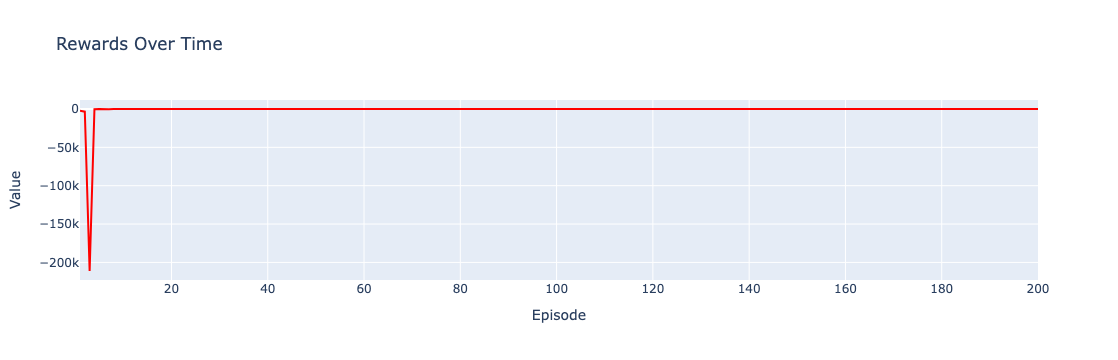

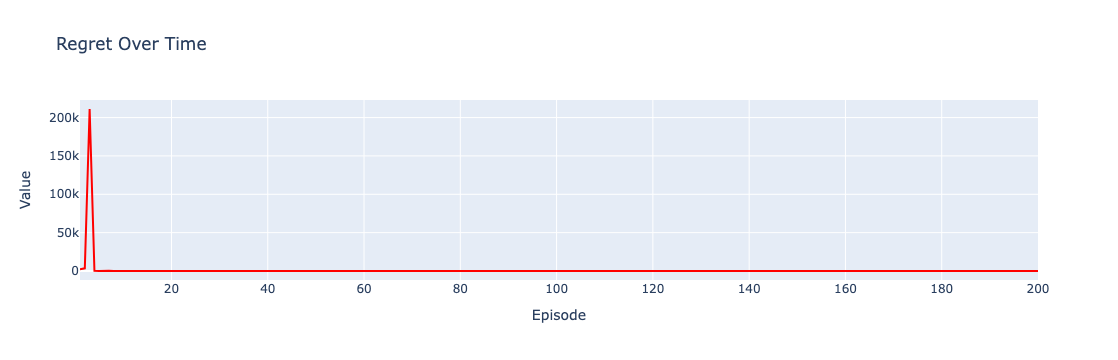

In [65]:
visualize(total_rewards, list(range(1, num_episodes+1)), 'Rewards')
visualize(regrets, list(range(1, num_episodes+1)), 'Regret')

For small values of n, the algorithm converges more steadily and reliably due to lower variance but may require more iterations to fully calculate accurate value estimates throughout the state space.  
On the other hand, for a large n, the algorithm tends to converge faster when rewards are sparse or delayed because they can effectively propagate reward information over long horizons.

### ج

In [72]:
class MonteCarlo:
    def __init__(self, env, discount=0.99, epsilon=1.0, epsilon_decay=None):
        self.env = env
        self.state_size = env.observation_space.n
        self.action_size = env.action_space.n
        self.q_table = np.zeros((self.state_size, self.action_size))
        self.c_table = np.zeros((self.state_size, self.action_size))  # Cumulative weights for importance sampling

        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01

        # Target policy (greedy with respect to Q-table)
        self.target_policy = np.zeros((self.state_size,), dtype=int)

    def get_behavior_action(self, state):
        """
        Generate action using the behavior policy (epsilon-greedy).
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def update_target_policy(self):
        """
        Update the target policy to be greedy with respect to the current Q-table.
        """
        self.target_policy = np.argmax(self.q_table, axis=1)

    def train(self, episodes):
        total_rewards = []

        for i in trange(episodes):
            state, _ = self.env.reset()
            episode = []

            # Generate an episode using the behavior policy
            while True:
                action = self.get_behavior_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode.append((state, action, reward))
                state = next_state
                if terminated or truncated:
                    break

            G = 0  # Return
            W = 1  # Importance sampling weight

            # Loop through the episode in reverse
            for state, action, reward in reversed(episode):
                G = self.discount * G + reward

                # Update cumulative weight only for the current (state, action) pair
                self.c_table[state, action] += W
                self.q_table[state, action] += (W / self.c_table[state, action]) * (G - self.q_table[state, action])

                # If the action taken does not match the target policy, stop updating
                if action != self.target_policy[state]:
                    break

                # Compute importance sampling weight for the next step
                W *= 1 / (1 / self.action_size if np.random.rand() < self.epsilon else 1)

            total_rewards.append(sum(x[2] for x in episode))

            # Decay epsilon (behavior policy exploration rate)
            if self.epsilon_decay and self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            # Update the target policy
            self.update_target_policy()

        return total_rewards


In [78]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()

num_episodes = 1000

discount = 0.9
epsilon = 1
epsilon_decay = 0.01


agent = MonteCarlo(env, discount=discount, epsilon=epsilon)
total_rewards = agent.train(num_episodes)

100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.39it/s]


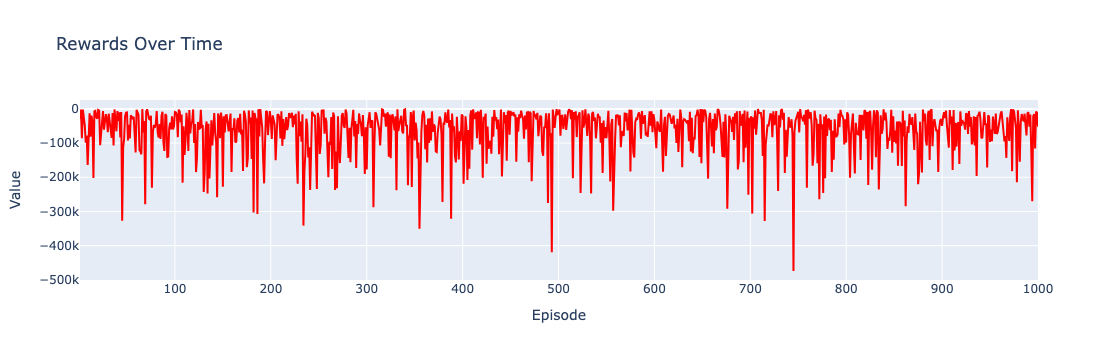

In [79]:
visualize(total_rewards, list(range(1, num_episodes+1)), 'Rewards')

In [83]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
env.reset()

num_episodes = 1000

discount = 0.9
epsilon = 1
epsilon_decay = 0.01


agent = MonteCarlo(env, discount=discount, epsilon=epsilon, epsilon_decay=epsilon_decay)
total_rewards = agent.train(num_episodes)

  0%|                                        | 1/1000 [00:08<2:23:34,  8.62s/it]


KeyboardInterrupt: 

In [ ]:
visualize(total_rewards, list(range(1, num_episodes+1)), 'Rewards')